In [2]:
import numpy as np
from os.path import join as pjoin
from os.path import isdir
import os
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import mne_bids
import mne
from mne_bids import write_raw_bids, BIDSPath
from scipy import stats
import re
from scipy import signal
import pandas as pd
from scipy import signal, fftpack

In [3]:
# define variables
sub_list = ['{0:0>2d}'.format(sub) for sub in np.arange(1,12)]
run_list = ['{0:0>2d}'.format(run) for run in np.arange(1,9)]
labels = ['LC', 'LF', 'LO', 'LP', 'LT', 'RC', 'RF', 'RO', 'RP', 'RT']

# set path
pre_root = '/nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids'
post_root = pjoin(pre_root, 'derivatives', 'preproc_meg-mne_mri-fmriprep')
results_pth = '/nfs/e5/studyforrest/forrest_movie_meg/tech_val_results'

In [4]:
def get_picks(data):
    # get valid channels
    ch_name_picks = mne.pick_channels_regexp(data.ch_names, regexp='M[LRZ]...-4503')
    type_picks = mne.pick_types(data.info, meg=True)
    picks= np.intersect1d(ch_name_picks, type_picks)
    return picks

def ilc_pick(ilc, ch_pairs):
    # select sensor correlation
    pick_corr = []
    for pair in ch_pairs:
        pick_corr.append(ilc[pair[1][0], pair[1][1]])
    
    return np.asarray(pick_corr)

def plot_topomap(val, meg_layout, title=None):
    """
    input params: val: [n_chn(272), 1]
                  meg_layout: mne Layout instance
                  title: str, title for plot, default to None
    """
    
    pos = meg_layout.pos[:,:2]
    x_min = np.min(pos[:,0])
    x_max = np.max(pos[:,0])
    y_min = np.min(pos[:,1])
    y_max = np.max(pos[:,1])
    center_x = (x_min + x_max)/2
    center_y = (y_min + y_max)/2
    layout_pos = np.zeros(pos.shape)
    for i, coor in enumerate(pos):
        layout_pos[i,0] = coor[0] - center_x
        layout_pos[i,1] = coor[1] - center_y
    
    vmin=np.percentile(val, 2)
    vmax=np.percentile(val, 98)
    fig = plt.figure()
    if title is not None:
        plt.title(title)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'))
    mne.viz.plot_topomap(val, layout_pos, vmin=vmin, vmax=vmax, cmap='viridis', sphere=np.array([0,0,0,0.5]))
    
    return fig

In [5]:
# load data
ilc_post = pd.read_pickle(pjoin(results_pth, 'ilc_post.pickle'))
ilc_pre = pd.read_pickle(pjoin(results_pth, 'ilc_pre.pickle'))

In [117]:
# exclude_ch = ['F21', 'F41', 'C11', 'C51', 'C61', 'C63', 'P21','P31' 'P51', 'O21', 'O41', 'F11', 
#              'F31', 'F51', 'F61', 'C12', 'C21', 'C52', 'C62', 'C55', 'O11', 'O31', 'O51']
# exclude_ch = [f'ML{chn}-4503' for chn in exclude_ch]
reg = re.compile('M...1-4503')
exclude_ch = list(filter(reg.match, ch_name))
# bad_ch = ['LF55', 'RT23', 'RT16']
for ch in ['MRF55-4503', 'MLT23-4503', 'MLT16-4503']:
    exclude_ch.append(ch)

In [139]:
sub_path = BIDSPath(subject='01', run='01', task='movie', session='movie', root='/nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids')
raw_sub = mne_bids.read_raw_bids(sub_path)
picks = get_picks(raw_sub)

ch_name = []
for idx in picks:
#     if raw_sub.ch_names[idx] not in exclude_ch:
    ch_name.append(raw_sub.ch_names[idx])

sym_ch_pairs = []
for i, ch1 in enumerate(ch_name):
    for ch2 in ch_name[i:]:
        if (not ch1==ch2) and (ch1[2:5]==ch2[2:5]):
            sym_ch_pairs.append([(ch1, ch2), (ch_name.index(ch1), ch_name.index(ch2))])

asym_ch_pairs = []
for i, ch1 in enumerate(ch_name):
    for ch2 in ch_name[i:]:
        if (not ch1[1] == 'Z') and (not ch2[1] == 'Z'):
            if (not ch1[2:5] == ch2[2:5]) and (not ch1[1]==ch2[1]):
                asym_ch_pairs.append([(ch1, ch2), (ch_name.index(ch1), ch_name.index(ch2))])

ds directory : /nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids/sub-01/ses-movie/meg/sub-01_ses-movie_task-movie_run-01_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       4.65   74.88    0.00 mm <->    4.65   74.88    0.00 mm (orig :  -65.68   46.24 -249.17 mm) diff =    0.000 mm
      -4.65  -74.88    0.00 mm <->   -4.65  -74.88   -0.00 mm (orig :   42.00  -58.24 -250.44 mm) diff =    0.000 mm
      92.94    0.00    0.00 mm <->   92.94   -0.00    0.00 mm (orig :   46.46   62.07 -225.18 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    Measurement info composed.
Finding samples for /nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids/sub-01/ses-movie/meg/sub-01_ses-movie_task-movie_run-01_meg.ds/sub-01_ses-movie_task-movie_run-01_meg.meg4: 
    System clock channel is availabl

In [140]:
for sub in sub_list:
    if sub == '01':
        run_ls = run_list + ['09']
    else:
        run_ls = run_list
    
    for run in run_ls: 
        if sub == '01' and run == '01':
            sym_corr = ilc_pick(ilc_post[sub][run], sym_ch_pairs)
            asym_corr = ilc_pick(ilc_post[sub][run], asym_ch_pairs)
        else:
            sym_corr += ilc_pick(ilc_post[sub][run], sym_ch_pairs)
            asym_corr += ilc_pick(ilc_post[sub][run], asym_ch_pairs)
#             sym_corr = np.append(sym_corr, ilc_pick(ilc_post[sub][run], sym_ch_pairs))
#             asym_corr = np.append(asym_corr, ilc_pick(ilc_post[sub][run], asym_ch_pairs))
        
sym_corr /= (11*8+1)
asym_corr /= (11*8+1)


Text(0.5, 1.0, 'Total Average')

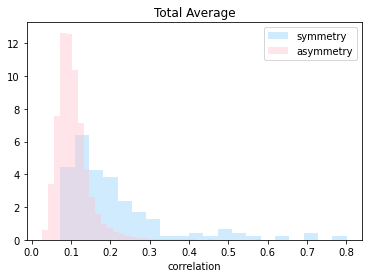

In [141]:
plt.hist(sym_corr, density=True, color='lightskyblue', bins=20, alpha=0.4, label='symmetry')
plt.hist(asym_corr, density=True, color='pink', bins=40, alpha=0.4, label='asymmetry')
plt.legend()
plt.xlabel('correlation')
plt.title('Total Average')

In [142]:
left_sensor = [pair[0][0] for pair in sym_ch_pairs]
right_sensor = [pair[0][1] for pair in sym_ch_pairs]
left_mean = np.zeros(len(sym_ch_pairs))
right_mean = np.zeros(len(sym_ch_pairs))
for i, chn in enumerate(left_sensor):
    n = 0
    lch = 0
    for j, pair in enumerate(asym_ch_pairs):
        if chn == pair[0][0]:
            lch += asym_corr[j]
            n += 1
    left_mean[i] = lch/n
    
for i, chn in enumerate(right_sensor):            
    m = 0
    rch = 0
    for j, pair in enumerate(asym_ch_pairs):
        if chn == pair[0][1]:
            rch += asym_corr[j]
            m += 1
    right_mean[i] = rch/m

diff_sym = np.append(left_mean, right_mean)

In [143]:
diff_val = np.zeros(269)
sensor = np.append(np.asarray(left_sensor), np.asarray(right_sensor))
for i, chn in enumerate(sensor):
    if not chn in exclude_ch:
        diff_val[ch_name.index(chn)] = diff_sym[i]

In [144]:
ilc_val = np.zeros(len(ch_name))
for i, pair in enumerate(sym_ch_pairs):
#     if not pair[0][0] in exclude_ch:
    ilc_val[ch_name.index(pair[0][0])] = sym_corr[i]

In [145]:
# extract layout
sub_path = BIDSPath(subject='01', run='01', task='movie', session='movie', root='/nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids')
raw_sub = mne_bids.read_raw_bids(sub_path)
meg_layout = mne.channels.find_layout(raw_sub.info, ch_type='meg')
intercorr_chn = []
ch_name_picks = mne.pick_channels_regexp(raw_sub.ch_names, regexp='M[LRZ]...-4503')
type_picks = mne.pick_types(raw_sub.info, meg=True)
picks= np.intersect1d(ch_name_picks, type_picks)
for idx in picks:
    intercorr_chn.append(raw_sub.ch_names[idx][:5])
exclude_list = [x for x in meg_layout.names if x not in intercorr_chn]
bad_ch = ['MRF55', 'MLT23', 'MLT16']
for ch in bad_ch:
    exclude_list.append(ch)

meg_layout = mne.channels.find_layout(raw_sub.info, ch_type='meg', exclude=exclude_list)


ds directory : /nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids/sub-01/ses-movie/meg/sub-01_ses-movie_task-movie_run-01_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       4.65   74.88    0.00 mm <->    4.65   74.88    0.00 mm (orig :  -65.68   46.24 -249.17 mm) diff =    0.000 mm
      -4.65  -74.88    0.00 mm <->   -4.65  -74.88   -0.00 mm (orig :   42.00  -58.24 -250.44 mm) diff =    0.000 mm
      92.94    0.00    0.00 mm <->   92.94   -0.00    0.00 mm (orig :   46.46   62.07 -225.18 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    Measurement info composed.
Finding samples for /nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids/sub-01/ses-movie/meg/sub-01_ses-movie_task-movie_run-01_meg.ds/sub-01_ses-movie_task-movie_run-01_meg.meg4: 
    System clock channel is availabl

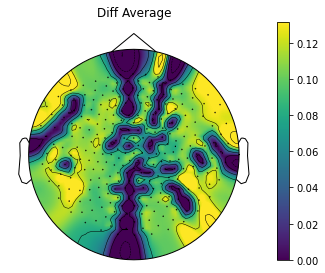

In [146]:
# fig1 = plot_topomap(ilc_val, meg_layout, title='Average')
fig2 = plot_topomap(diff_val, meg_layout, title='Diff Average')